# Systematics modeling

Unaccounted-for systematics appear to be causing the anomolous DES Y1 cluster cosmology results. Specifically, systematics in the lensing models could be causing us to recover incorrect mean masses for the stacks.

In this notebook, I will take the lensing ratio data (the ratio between lensing profiles of clusters in Buzzard selected by redMaPPer to profiles of clusters selected to have matched mass and redshift distributions), and fit a model to the ratio. This is important because the ratios have noise, and we want to propagate that noise into the mass estimates.

The steps I take here will be:
1. Read in the ratio data, and check that they are read in correctly.
2. Design a quadratic model in $\ln(R)$ (possibly with intrinsic scatter) for the ratio.
3. Fit the ratio profiles with the model using an optimizer.
4. Obtain parameter constraints using an MCMC.

In [1]:
import numpy as np
import scipy.optimize as op
import emcee
import corner
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
plt.rc("font", size=14, family="serif")
plt.rc("text", usetex=True)

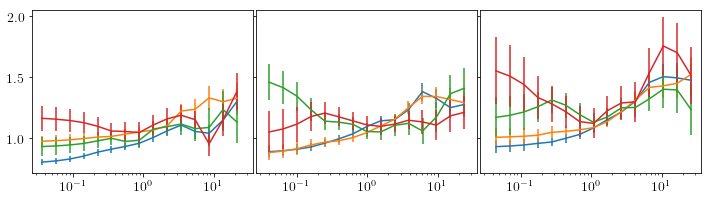

In [38]:
#Read in the ratio data and plot them
inpath = "X_ratios_for_Y1/X_ratio_z%d_l%d_v3.txt"
fig, ax = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(12,3))
for i in range(3):
    for j in range(4):
        R, X, Xerr = np.loadtxt(inpath%(i, j+3), unpack=True)
        ax[i].errorbar(R, X, Xerr)
ax[0].set_xscale("log")
plt.subplots_adjust(wspace=0.01)

## Generative model for $X(R)$

We now write down a generative model for $X(R)$, where (for now) we will fit one richness--redshift bin at a time. The model will be
$$
\langle X|R,z,\lambda,a,b,c\rangle = a(\ln R)^2 + b\ln R + c
$$
With a Gaussian likelihood where the covariance matrix is diagonal and given by the estimated errors on $X(R)$.
$$
P(\{X_i\}|z,\lambda,a,b,c) = \sum_i\frac{1}{\sqrt{2\pi\sigma^2_i}}\exp\left(-\frac{[X_i-\langle X_i|R_i,z,\lambda,a,b,c\rangle]^2}{2\sigma_i^2} \right)
$$

In [11]:
def ratio_model(params, args):
    a, b, c = params[:3]
    lnR = args["lnR"]
    return a*lnR**2 + b*lnR + c

In [14]:
def lnlike(params, args):
    X_data = args["X"]
    X_variance = args["X_variance"]
    X_model = ratio_model(params, args)
    lnL = np.sum( (X_data-X_model)**2/X_variance + np.log(2*np.pi*X_variance) )
    return -0.5*lnL

def lnprior(params, args):
    #a, b, c = params[:3]
    return 0

def lnprob(params, args):
    lnp = lnprior(params, args)
    if np.isinf(lnp): 
        return -1e99
    else: 
        return lnp + lnlike(params, args)

In [26]:
#A function for getting an arguments dictionary
def assemble_args(zi, lj):
    R, X, Xerr = np.loadtxt(inpath%(zi, lj), unpack=True)
    args = {}
    args["R"] = R
    args["lnR"] = np.log(R)
    args["X"] = X
    args["X_error"] = Xerr
    args["X_variance"] = Xerr**2
    return args

      fun: -10.215981124312332
 hess_inv: array([[ 2.30630078e-04, -5.84077278e-05, -5.07701703e-04],
       [-5.84077278e-05,  8.36397265e-04,  8.69772634e-05],
       [-5.07701703e-04,  8.69772634e-05,  2.93682941e-03]])
      jac: array([ 1.19209290e-07,  2.38418579e-07, -1.19209290e-07])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.04851261, 0.0198047 , 1.19427593])


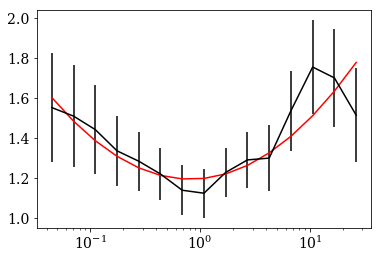

In [18]:
#Fit a single bin
guess = np.array([1., 1., 1.])
args = assemble_args(0, 3)
nll = lambda *args: -lnprob(*args)
result = op.minimize(nll, guess, args=(args,))
print(result)

#Plot it
X_model = ratio_model(result.x, args)
plt.errorbar(args["R"], args["X"], args["X_error"], c='k')
plt.plot(args["R"], X_model, c="r")
plt.xscale("log")

In [27]:
#Fit all bins at once
result_array = []
for zi in range(3):
    res_arr = []
    for lj in range(3, 7):
        guess = np.array([1., 1., 1.])
        args = assemble_args(zi, lj)
        nll = lambda *args: -lnprob(*args)
        result = op.minimize(nll, guess, args=(args,))
        res_arr.append(result.x)
        print(result.x)
    result_array.append(res_arr)
print("Fitting done")

[0.00372101 0.06640197 0.97592623]
[0.01246956 0.0648705  1.06645654]
[0.00417363 0.04336787 1.02721677]
[0.01119432 0.00907297 1.0839998 ]
[0.00470022 0.08431587 1.08341338]
[0.0093933  0.08876706 1.06546057]
[ 0.0363378  -0.02124831  1.0693039 ]
[1.92525521e-03 5.35669039e-04 1.13357606e+00]
[0.01913358 0.10859871 1.08392714]
[0.01874641 0.08532298 1.10817765]
[0.01019216 0.0174967  1.20929312]
[0.04851261 0.0198047  1.19427593]
Fitting done


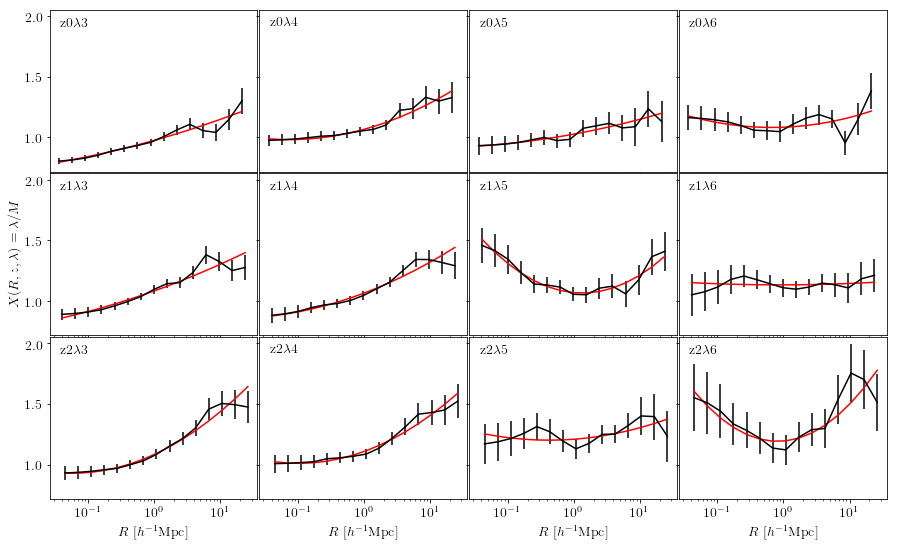

In [39]:
#Plot them all
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(15,9))
plt.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(3):
    for j in range(4):
        args = assemble_args(i, j+3)
        X_model = ratio_model(result_array[i][j], args)
        ax[i][j].errorbar(args["R"], args["X"], args["X_error"], c='k')
        ax[i][j].plot(args["R"], X_model, c="r")
        ax[i][j].text(0.05, 0.9, r"z%d$\lambda$%d"%(i,j+3), transform=ax[i][j].transAxes)
        if i == 2:
            ax[i][j].set_xlabel(r"$R\ [h^{-1}{\rm Mpc}]$")
ax[0][0].set_xscale("log")
ax[1][0].set_ylabel(r"$X(R,z,\lambda)= \lambda/M$")
fig.savefig("fit_panel.png", dpi=300, bbox_inches="tight")